In [1]:
import os
import getpass

from utils import *
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
#Apparently deprecated
#from scipy.misc import imresize
import cv2

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Model Training

In [3]:
TRAIN = True
#user defined variables
IMG_SIZE    = 128
BATCH_SIZE  = 64

#DATASET_DIR = '/home/mcv/datasets/MIT_split'
#MODEL_FNAME = '/home/group01/work/my_first_mlp.h5'
DATASET_DIR = '../../MIT_split'
MODEL_FNAME = '../../my_first_mlp.h5'

In [4]:
if not os.path.exists(DATASET_DIR):
  print(Color.RED, 'ERROR: dataset directory '+DATASET_DIR+' do not exists!\n')

In [5]:
if TRAIN:
    print('Building MLP model...\n')

    #Build the Multi Layer Perceptron model
    model = Sequential()
    model.add(Reshape((IMG_SIZE*IMG_SIZE*3,), input_shape=(IMG_SIZE, IMG_SIZE, 3), name='first'))
    model.add(Dense(units=2048, activation='relu',name='second'))
    model.add(Dense(units=1024, activation='relu', name='third'))
    model.add(Dense(units=512, activation='relu', name='fourth'))
    model.add(Dense(units=258, activation='relu', name='fifth'))
    model.add(Dense(units=8, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer='sgd',
                metrics=['accuracy'])

    print(model.summary())
    #plot_model(model, to_file='modelMLP.png', show_shapes=True, show_layer_names=True)

    print('Done!\n')

Building MLP model...

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first (Reshape)             (None, 49152)             0         
                                                                 
 second (Dense)              (None, 2048)              100665344 
                                                                 
 third (Dense)               (None, 1024)              2098176   
                                                                 
 fourth (Dense)              (None, 512)               524800    
                                                                 
 fifth (Dense)               (None, 258)               132354    
                                                                 
 dense (Dense)               (None, 8)                 2072      
                                                                 
Total params: 103,422,746
Trainab

In [6]:
if TRAIN:
    if os.path.exists(MODEL_FNAME):
        print('WARNING: model file '+MODEL_FNAME+' exists and will be overwritten!\n')

    print('Start training...\n')

    # this is the dataset configuration we will use for training
    # only rescaling
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True)

    # this is the dataset configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            DATASET_DIR+'/train',  # this is the target directory
            target_size=(IMG_SIZE, IMG_SIZE),  # all images will be resized to IMG_SIZExIMG_SIZE
            batch_size=BATCH_SIZE,
            classes = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding'],
            class_mode='categorical')  # since we use binary_crossentropy loss, we need categorical labels

    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            DATASET_DIR+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding'],
            class_mode='categorical')

    history = model.fit(
            train_generator,
            steps_per_epoch=1881 // BATCH_SIZE,
            epochs=150,
            validation_data=validation_generator,
            validation_steps=807 // BATCH_SIZE)

    print('Done!\n')
    print('Saving the model into '+MODEL_FNAME+' \n')
    model.save_weights(MODEL_FNAME)  # always save your weights after training or during training
    print('Done!\n')


Start training...

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Epoch 1/150
29/29 [==============================] - 3s 86ms/step - loss: 2.0151 - accuracy: 0.2042 - val_loss: 1.8256 - val_accuracy: 0.3333
Epoch 2/150
29/29 [==============================] - 2s 82ms/step - loss: 1.8724 - accuracy: 0.3038 - val_loss: 2.0301 - val_accuracy: 0.2852
Epoch 3/150
29/29 [==============================] - 2s 81ms/step - loss: 1.7821 - accuracy: 0.3330 - val_loss: 1.7476 - val_accuracy: 0.3802
Epoch 4/150
29/29 [==============================] - 2s 80ms/step - loss: 1.6866 - accuracy: 0.3759 - val_loss: 1.6357 - val_accuracy: 0.4010
Epoch 5/150
29/29 [==============================] - 2s 80ms/step - loss: 1.6190 - accuracy: 0.4095 - val_loss: 1.7239 - val_accuracy: 0.3932
Epoch 6/150
29/29 [==============================] - 2s 80ms/step - loss: 1.5775 - accuracy: 0.4331 - val_loss: 1.5466 - val_accuracy: 0.4518
Epoch 7/150
29/29 [==========================

prediction for image ../../MIT_split/test/coast\art1130.jpg
[[2.6177073 0.        0.        ... 1.7897455 2.3451347 0.2257738]]
Features shape : (1, 2048)
Done!


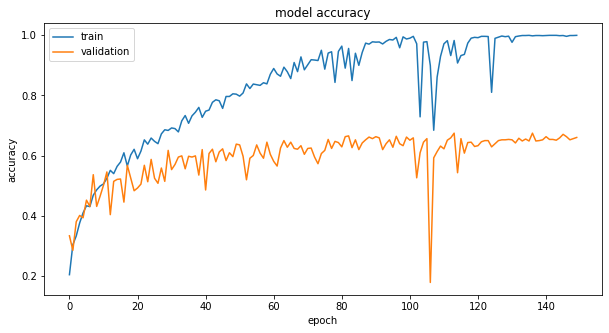

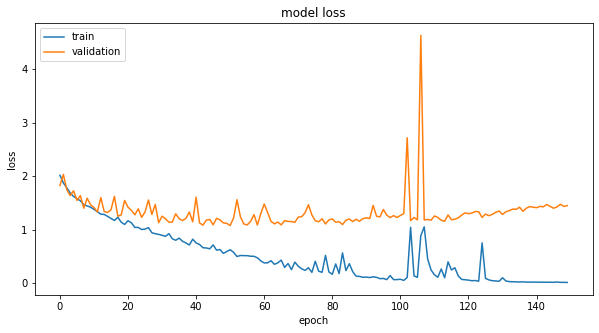

In [7]:
if TRAIN:
    # summarize history for accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('accuracy.jpg')
    #plt.close()
    # summarize history for loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('loss.jpg')

    #to get the output of a given layer
    #crop the model up to a certain layer
    model_layer = Model(inputs=model.input, outputs=model.get_layer('second').output)

    #get the features from images
    directory = DATASET_DIR+'/test/coast'
    x = np.asarray(Image.open(os.path.join(directory, os.listdir(directory)[0] )))
    x = np.expand_dims(cv2.resize(x, (IMG_SIZE, IMG_SIZE)), axis=0)
    print('prediction for image ' + os.path.join(directory, os.listdir(directory)[0] ))
    features = model_layer.predict(x/255.0)
    print(features)
    print(f"Features shape : {features.shape}")
    print('Done!')

# Analysis

## Trained models against previous techniques

In [8]:
#Build the Multi Layer Perceptron model
model = Sequential()
model.add(Reshape((IMG_SIZE*IMG_SIZE*3,), input_shape=(IMG_SIZE, IMG_SIZE, 3), name='first'))
model.add(Dense(units=2048, activation='relu',name='second'))
model.add(Dense(units=1024, activation='relu', name='third'))
model.add(Dense(units=512, activation='relu', name='fourth'))
model.add(Dense(units=258, activation='relu', name='fifth'))
model.add(Dense(units=8, activation='softmax'))

In [9]:
#Load Model Weight
MODEL_LOAD_NAME = '../../my_first_mlp.h5'
model.load_weights(MODEL_LOAD_NAME)

ValueError: Cannot assign value to variable ' second/kernel:0': Shape mismatch.The variable shape (49152, 2048), and the assigned value shape (196608, 2048) are incompatible.

In [ ]:
directory = DATASET_DIR+'/test/coast'
x = np.asarray(Image.open(os.path.join(directory, os.listdir(directory)[1] )))
x = np.expand_dims(cv2.resize(x, (IMG_SIZE, IMG_SIZE)), axis=0)

model.predict(x)

directory = DATASET_DIR+'/test'
classes = {'coast':0,'forest':1,'highway':2,'inside_city':3,'mountain':4,'Opencountry':5,'street':6,'tallbuilding':7}
correct = 0.
total   = 807
count   = 0

for class_dir in os.listdir(directory):
    cls = classes[class_dir]
    for imname in os.listdir(os.path.join(directory,class_dir)):
      im = np.asarray(Image.open(os.path.join(directory,class_dir,imname)))
      im = np.expand_dims(cv2.resize(im, (IMG_SIZE, IMG_SIZE)), axis=0)
      out = model.predict(im)
      predicted_cls = np.argmax( out )
      if predicted_cls == cls:
        correct+=1
      count += 1
      print('Evaluated images: '+str(count)+' / '+str(total), end='\r')
    
colorprint(Color.BLUE, 'Done!\n')
colorprint(Color.GREEN, 'Test Acc. = '+str(correct/total)+'\n')

Done!images: 807 / 807
Test Acc. = 0.6133828996282528
